# Land-Use Classification on EuroSAT Dataset With Computer Vision Features Extraction Techniques

## Introduction

Satellite imagery has become a critical tool for land-use management due to its cost-effectiveness and efficiency in collecting data on large areas. Sentinel-2 is a joint satellite mission of the European Space Agency (ESA) and EC (European Commission) that captures high-resolution images of the Earth's surface. These images have been applied in various fields such as agriculture, forestry, urban planning, and disaster management. This paper presents a multi-class classification patch-based method for analyzing Sentinel-2 satellite images to identify land use and land cover.

## Problem Statement

Accurately classifying land use from satellite images is essential for effective land-use management. Traditional land-use mapping methods require human field surveys, which can be time-consuming and expensive. Satellite imagery provides an efficient way to collect data over large areas. However, interpreting satellite imagery at scale and to the expected detail is challenging due to image complexity and variability. Thus, there is a need for automated methods to classify land use from satellite images. This paper proposes a machine learning-based approach that utilizes Sentinel-2 satellite patch-based imagery to classify land use into multiple classes. This approach provides valuable insights into land-use management and can be used in the aforementioned applications.

## Background

In their paper titled [“EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification”](https://www.researchgate.net/publication/319463676
), Helber, Bischke, Dengel, Borth discussed how they created the EuroSAT satellite image dataset. They described the preprocessed steps they took to strengthen the number of satellite images per category (class), filter mislabeled or broken image (e.g., satellites images with cloud, ice, or snow), and ensure high intra-class variance inherent to remotely sensed images by sampling from various European countries and over a variety of land use and land cover classes. This means our satellite image classifier would inherently have limitations in classifying satellite images that contain cloud, ice, or snow due to the nature of the EuroSAT dataset.

It is important to note that the dataset has not received any atmospheric correction which results in color cast in some satellite images. That may potentially impact how color-related features (i.e., color histogram) allow our proposed classifiers to distinguish between land cover/use classes.

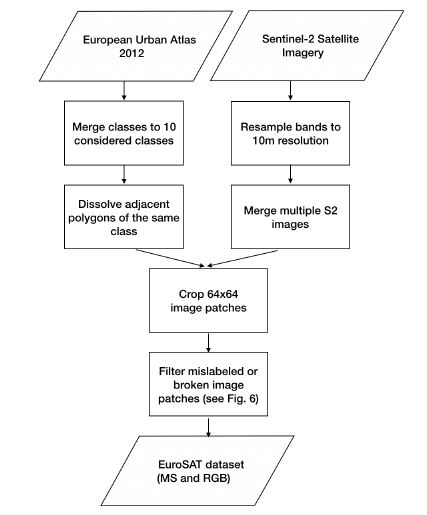

The paper provides a classification accuracy benchmark on trained SVM (with Bag-of-Visual-Words, BoVW approach using SIFT features), Convolutional Neural Network (CNNs), ResNet-50 and GoogleNet models. As expected, the neural network models outperformed conventional ML models (e.g. SVM). The best accuracy that was achieved by their SVM models was around 70% based on a 80-20 training-test data split.

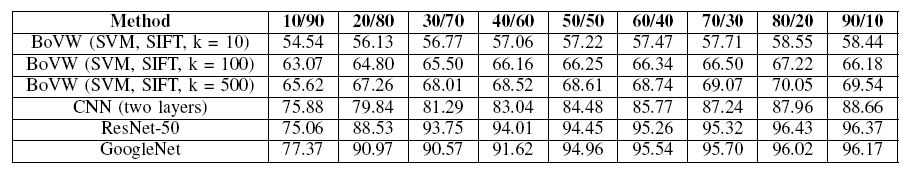

The authors then evaluated a fine-tuned ResNet-50 CNN model on red-green-blue (RGB), shortwave-infrared (SWIR) and color-infrared (CI) band combinations dataset and concluded that the ResNet-50 model trained with RGB-space images performed the best in terms of classification accuracy. Based on this result, our team decided to focus on the RGB images for our land use/cover classifier.

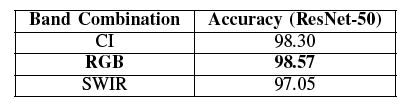

## Dataset Overview
Land use and land cover classification based on Sentinel-2 satellite images. Patches are extracted with the purpose to identify classes. Sentinel-2 is a joint satellite mission of the European Space Agency (ESA) and EC (European Commission) that captures high-resolution images of the Earth's surface.
Specifically, the proposed EuroSAT dataset consists of 27,000 labeled images with 10 different land use and land cover classes. The 10 categories include Annual Crop, Forest, Herbaceous Vegetation, Highway, Industrial, Pasture, Permanent Crop, Residential, River, and Sea/Lake, each representing a distinct type of land use or cover. A significant difference to previous datasets is that the presented satellite image dataset is multi-spectral covering 13 spectral bands in the visible, near infrared and short wave infrared part of the spectrum. In addition, the proposed dataset is georeferenced and based on openly and freely accessible Earth observation data allowing a unique range of applications. The labeled dataset EuroSAT is made publicly available at https://github.com/phelber/eurosat. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Standard library imports
import concurrent.futures
import json
import os
import matplotlib.pyplot as plt
# Third-party imports
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from scipy.ndimage import convolve
from skimage import feature, io, color, transform, exposure
from skimage.color import rgb2gray, rgb2lab, gray2rgb
from skimage.feature import hog, local_binary_pattern, blob_dog, graycomatrix, graycoprops
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.sequence import pad_sequences
import concurrent.futures
import functools
import scipy.cluster
import warnings
warnings.filterwarnings("ignore")

In [ ]:
info_img=json.load(open('/content/drive/MyDrive/eurosat/rgb/2.0.0/image.image.json'))
info_label=list(open('/content/drive/MyDrive/eurosat/rgb/2.0.0/label.labels.txt','r'))

In [ ]:
print(info_img)

{'encoding_format': 'png', 'shape': [64, 64, 3]}


In [ ]:
for i in enumerate (info_label):
    print(i[0],i[1])

0 AnnualCrop

1 Forest

2 HerbaceousVegetation

3 Highway

4 Industrial

5 Pasture

6 PermanentCrop

7 Residential

8 River

9 SeaLake



In [ ]:
raw_dataset = tf.data.TFRecordDataset("/content/drive/MyDrive/eurosat/rgb/2.0.0/eurosat-train.tfrecord-00000-of-00001")
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

In [ ]:
# Define the feature description
feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

In [ ]:
# Parse the protobuf message
def parse_function(example_proto):
    """
    uses tf.io.parse_single_example to parse a single example from a serialized data. 
    feature_description is assumed to be defined globally 
    which describes the expected features in the serialized data.
    """
    return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = raw_dataset.map(parse_function)

In [ ]:
# Convert the parsed_dataset to a pandas DataFrame
def dataset_to_dataframe(parsed_dataset):
    data = []
    for sample in parsed_dataset.as_numpy_iterator():
        filename, image, label = sample['filename'], sample['image'], sample['label']
        row = {'filename': filename, 'image': image, 'label': label}
        data.append(row)

    return pd.DataFrame(data)

parsed_dataframe = dataset_to_dataframe(parsed_dataset)
display(parsed_dataframe.head())

filename  \
0        b'SeaLake_2401.jpg'   
1  b'PermanentCrop_1790.jpg'   
2         b'SeaLake_649.jpg'   
3     b'Industrial_1649.jpg'   
4        b'Pasture_1418.jpg'   

                                               image  label  
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      9  
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      6  
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      9  
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      4  
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...      5

In [ ]:
# Define a function to decode the image data
def decode_image(image_data):
    """
    takes an image image_data in JPEG format and 
    applies a series of preprocessing steps. 
    It first decodes the JPEG image into a 3D tensor of shape [height, width, channels] 
    using tf.image.decode_jpeg. 
    It then resizes the image to a fixed size of 224x224 using tf.image.resize. 
    The image is then converted to float32 and normalized to have pixel values in the range [0, 1].
    Then it returns the numpy array of the image.
    """
    if isinstance(image_data, tf.Tensor) and image_data.dtype == tf.uint8:
        image_data = tf.io.serialize_tensor(image_data)
        image_data = tf.io.encode_jpeg(image_data)
        image = tf.image.decode_jpeg(image_data, channels=3)
    else:
        image = tf.image.decode_jpeg(image_data, channels=3)

    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    return image.numpy()

##Feature Extraction


###HSV color histogram
HSV (Hue, Saturation, and Value) is an alternative color representation model to the widely used RGB (Red, Green, and Blue) model. In the given code, we use HSV color histograms to analyze and quantify the color distribution in images. The reason for choosing the HSV model is that it provides a more intuitive and perceptually meaningful representation of colors. Unlike RGB, which considers colors in terms of their primary components, HSV separates color information (hue) from brightness (value) and saturation, making it more closely aligned with the way humans perceive colors. This separation of color and intensity information allows the algorithm to be more robust and less sensitive to changes in lighting conditions. By using the HSV color channel in the color_histogram function, we can capture more meaningful and discriminative color features that can help improve the performance of image analysis tasks.


In [ ]:
# Function to compute color histograms
def color_histogram(image, nbins=32, channel='hsv'):
    """
    Computes color histograms for the given image.
    
    Args:
    image (ndarray): Input image.
    nbins (int): Number of bins for the histograms.
    channel (str): Color channel to use, can be 'rgb' or 'hsv'.
    
    Returns:
    hist (ndarray): Concatenated histograms of color channels.
    """
    if channel == 'hsv':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
    chans = cv2.split(image)
    hist = []
    
    for chan in chans:
        hist.append(cv2.calcHist([chan], [0], None, [nbins], [0, 256]))
    
    hist = np.concatenate(hist).flatten()
    return hist


###Local Binary Pattern (LBP)

Local Binary Patterns (LBP) is a powerful texture descriptor that captures the local structure and texture of objects in images. In the given code, we use LBP to extract texture-based features. LBP works by comparing each pixel with its neighbors in a circular neighborhood, encoding the binary differences as a unique pattern. These patterns effectively represent the micro-level texture information present in the image.

The `local_binary_patterns` function takes an input image, a specified number of points to sample in the circular neighborhood, and a radius for the neighborhood. It first converts the image to grayscale, as LBP works best on single-channel images. Then, it computes the LBP descriptor using the uniform mapping method, which reduces the number of possible patterns and enhances the discriminative power of the descriptor. Finally, it generates a histogram of the LBP patterns, normalizing it to create a feature vector.

Using LBP features enables the analysis of shape and texture characteristics in images, which can improve the performance of various image processing tasks by providing a complementary perspective to color-based features like HSV histograms.

In [ ]:
# Function to compute Local Binary Patterns
def local_binary_patterns(image, num_points=24, radius=8):
    """
    Computes Local Binary Patterns for the given image.
    
    Args:
    image (ndarray): Input image.
    num_points (int): Number of points to sample in the circular neighborhood.
    radius (int): Radius of the circular neighborhood.
    
    Returns:
    lbp_hist (ndarray): Histogram of Local Binary Patterns.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, num_points, radius, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist


###Histogram of Oriented Gradients (HOG) 

Histogram of Oriented Gradients (HOG) is a feature extraction technique used to capture the local shape information and edge structures in images. It works by calculating the gradients of an image and creating histograms of the gradient orientations within localized regions or cells.

The `histogram_of_oriented_gradients `function in the given code computes the HOG features for an input image. It first converts the image to grayscale, as HOG is typically applied to single-channel images. Then, the function takes the following parameters: the number of orientation bins, the size of a cell in pixels, and the number of cells in each block. It computes the HOG features using the feature.hog method from the skimage library.

HOG features are particularly useful for object detection and recognition tasks, as they capture the structural information of objects in an image, which is complementary to color-based features like HSV histograms and texture-based features like Local Binary Patterns (LBP). By including HOG features in the analysis, it is possible to improve the overall performance and robustness of image processing algorithms.

In [ ]:
# Function to compute Histogram of Oriented Gradients
def histogram_of_oriented_gradients(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Computes Histogram of Oriented Gradients for the given image.
    
    Args:
    image (ndarray): Input image.
    orientations (int): Number of orientation bins.
    pixels_per_cell (tuple): Size of a cell in pixels.
    cells_per_block (tuple): Number of cells in each block.
    
    Returns:
    hog_features (ndarray): Histogram of Oriented Gradients features.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = feature.hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, transform_sqrt=True, block_norm="L1")
    return hog_features

### Fourier Descriptors

Our team also extracted the magnitude of the Fourier Transform of our image dataset in an attempt to extract the geometric structure of the spatial domain of our given images. This feature should provide information about how various frequencies are attenuated and accentuated for a given image (texture patterns), which could be important to enable our classifier to identify subtle differences in signatures between satellite images from various land-use/land-cover classes.

In [ ]:
def extract_fourier_descriptor(image):
    """
    Takes an image as input and perform a Fourier transform. Then shift
    the zero-frequencyt component to the center of the spectrum and extract
    the magnitude 
    
    Args:
    image (ndarray): Input image

    Returns:
    magnitude_spectrum (ndarray): A flatten numpy array that contain the magnitude of the
    Fourier Tranform of the given image that has an original shape of (244, 244)
    """
    if image.shape[-1] == 3:
        image = rgb2gray(image)
    # Compute the DFT of the image
    fourier_des = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    # shift zero-ferquency component to teh center of the spectrum
    fourier_des = np.fft.fftshift(fourier_des)
    # extract the magnitdue from the fourier tranform of the image
    magnitude_spectrum = 20*np.log(cv2.magnitude(fourier_des[:,:,0],fourier_des[:,:,1]))

    return magnitude_spectrum.flatten()

### Super Linear Iterative Clustering (SLIC) Features

Super Linear Iterative Clustering (SLIC) is a superpixels algorithm that groups pixels into perceptually meaningful regions (segmentation) by k-means clustering pixels based on their similarity and proximity in space. Here our team implements a binary mask that tells the SLIC algorithm to generate superpixels only within the region of interest (ROI) defined by the mask. The mask is created by removing small bright regions (via function `skimage.morphology.remove_small_objects`) and filling small holes while preserving larger shapes (via function `skimage.morphology.remove_small_holes`) for each of the satellite image data. The SLIC algorithm provides segment labels within the region of interest for each satellite image. 

In [ ]:
def extract_slic(image, n_segments=30, min_size=6):
    """
    Takes an image as input and extracts superpixel segmentation using k-mean clustering 
    in color-position space with a mask that remove any holes or object smaller than
    certain pixels
    
    Args:
    image (ndarray): Input image
    n_segments (int): The (approximate) number of labels in the segmented output image
    min_size (int): The largest allowable object size or the maximum area, in pixels, of a contiguous hole that will be filled

    Returns:
    segments_slic (ndarray): A flatten integer mask indicating segment labels that has an originally shape (224, 224)
    """
    # Convert image to grayscale
    grayscale_image = rgb2gray(image)

    # Thresholding
    threshold= threshold_otsu(grayscale_image)
    binary_image = grayscale_image > threshold
    
    # Remove any holes or objects smaller than certain pixels (default = 6 pixels, 10% of the input photo)
    mask = remove_small_holes(remove_small_objects(binary_image, min_size=min_size), area_threshold=min_size)
    segments_slic  = slic(image, n_segments=n_segments, mask=mask, start_label=1)
    return segments_slic.flatten()

### Scale-Invariant Feature Transform (SIFT) Features and Bag-of-Visual-Words (BoVW) Approach

The Scale-Invariant Feature Transform (SIFT) algorithm is a scale and rotation-invariant method to extract local features from images. And its robustness to variations in illumination and noise makes it an ideal choice for feature extractions on our satellite images, which often could be taken in various scales and rotational angles. The descriptors extracted from SIFT algorithm forms a “Bag-of-Visual-Words (BoVW)” dictionary which contains vocabulary that represents “common” key points that are extracted from the satellite images. The “Bag-of-Visual-Words (BoVW)” vocabulary are defined as cluster centers from a collection of SIFT descriptors via k-mean clustering. Then we use the “Bag-of-Words” technique to compute a histogram of “word-count” to show how frequently certain vocabulary (BoVW feature) appears in our satellite image dataset.


In [ ]:
# Function to compute SIFT Keypoints and Descriptors
def extract_sift(image, nfeatures=0, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6):
    """
    This function takes an image as input and extracts SIFT keypoint and descriptor
    features as tuples.
    
    Args:
        image (numpy.array): The input image.
        nfeatures (int): The number of best features to retain.
        contrastThreshold (float): The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
        edgeThreshold (float): The threshold used to filter out edge-like features.
        sigma (float): The sigma of the Gaussian applied to the input image at the octave #0.

    Returns:
        kp (list): A list of detected keypoints.
        des (numpy.array): A 2D array of shape (Number_of_keypoints, 128) containing the descriptors.
    """
    if len(image.shape) == 2:
       gray = image.astype(np.uint8)
    elif image.shape[-1] == 3:
       gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
       gray = gray.astype(np.uint8)
    else:
       raise ValueError("Unsupported image format")

    assert gray.dtype == np.uint8, f"Expected image depth CV_8U, got {gray.dtype}"

    sift = cv2.SIFT_create(nfeatures=nfeatures, contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, sigma=sigma)
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des


In [ ]:
def build_BoVW(descriptors_list, vocabulary_size=200):
    descriptors = np.concatenate(descriptors_list)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, bovw = cv2.kmeans(descriptors.astype(np.float32), vocabulary_size, None, criteria, 10, flags)
    return bovw

def extract_BoVW_features(image, bovw):
    kp_sift, des_sift = extract_sift(image)
    # initialize the feature vector
    bovw_features = np.zeros((1, bovw.shape[0]), dtype=np.float32)
    if des_sift is not None:
        features, _ = scipy.cluster.vq.kmeans(descriptors.astype(np.float32), vocabulary)


### Gray Level Co-occurrence Matrices (GLCM) Features for Texture Extraction

In the paper titled “[Practical guidelines for choosing GLCM textures to use in landscape classification tasks over a range of moderate spatial scales](https://www.tandfonline.com/doi/abs/10.1080/01431161.2016.1278314)”, Hall-Beyer demonstrated that extracting GLCM textures can provide visual edges representation of land-cover patches (from contrast, dissimilarity, entropy) and patch interiors representation (from correlation, ASM) for land-cover/land-use classification. To capture these GLCM textures, we decided to produce GLCMs with the closest neighbors (pixels with an offset of 1) in all direction (0, 45, 90, 135 degree), and use them to compute six texture properties that are associated with the GLCMs: 

- Contrast measures the local variations in GLCM.
Dissimilarity measures the difference between pixels in terms of their gray-level intensities.
- Homogeneity measures how close the distribution of elements in the GLCM is to the GLCM diagonal.
- Angular Second Moment (ASM) measures the uniformity of distribution of gray levels.
- Entropy (energy) measures the randomness of distribution of gray levels
- Correlation measures how correlated a pixel is to its neighbor over the image


In [ ]:
def extract_glcm(image):
    """
    Takes an image as input and extracts Gray-Level Co-Occurrence Matrix (GLCM)
    to compute spatial relationships of pixels in the given image (texture), and
    represent these relationship as a vector
    
    Args:
    image (ndarray): Input image

    Returns:
    glcm_vector (ndarray): A numpy array that contain values of six texture properties
    from a GLCM extract from the given image: 
    contrast, dissimilarity, homogeneity, Angular Second Moment (ASM), entropy and correlation
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)*255
    image = np.uint8(image)
    # Compute GLCM matrix with distance [1] and angles [0,45,90,135] degrees
    glcm = graycomatrix(image, [1], [0,np.pi/4,np.pi/2,3*np.pi/4], symmetric=True, normed=True)

    # Compute texture properties of a GLCM: homogeneity, dissimilarity, contrast, entropy and Angular Second Moment
    contrast = graycoprops(glcm, 'contrast')[0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0]
    asm = graycoprops(glcm, 'ASM')[0]
    energy = graycoprops(glcm, 'energy')[0]
    correlation = graycoprops(glcm, 'correlation')[0]
    # package all texture values as a glcm vector
    glcm_vector = np.concatenate((contrast,
                                  dissimilarity,
                                  homogeneity,
                                  asm,
                                  energy,
                                  correlation))
    return glcm_vector

###VGG
The VGG-16 model is a deep convolutional neural network designed for image recognition tasks. It has proven to be highly effective in extracting hierarchical and abstract features from images, which can be used for various computer vision applications.

The `extract_vgg16_features` function is used to extract features from a set of input images using the VGG-16 model. 

The input images are preprocessed using the VGG-16 specific preprocessing method, which includes resizing, normalization, and channel reordering. The preprocessed images are then fed into the intermediate model to obtain the features. The extracted features can be utilized for various image analysis tasks, such as classification, clustering, or similarity search.

The `decode_image_vgg`function is used to preprocess a single input image, making it compatible with the VGG-16 model. It decodes the JPEG image, resizes it to the required dimensions (224x224), and normalizes the pixel values using the VGG-16 preprocessing method. This preprocessed image can then be fed into the extract_vgg16_features function for feature extraction.

In [ ]:
# Extract features
def extract_vgg16_features(images, layer_name):
    # Load the VGG16 model
    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Get the output of the desired layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    # Preprocess the input images
    preprocessed_images = np.array([preprocess_input(image) for image in images])
    # Extract the features
    features = intermediate_layer_model.predict(preprocessed_images)
    return features

def decode_image_vgg(image):
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [224, 224])
    # Normalize the pixel values
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image


## Methodology
Our objective for this project is to reach high accuracy in classifying satellite images into 10 classes of land-use/land cover types.  Our EuroSAT dataset has already been preprocessed to remove satellite images that contain artifacts such as clouds, snow, or ice, which can hide crucial information to distinguish land-use/land-cover types. Yet, there are still several challenges in creating a highly accurate and robust classifier for this task:
- It requires distinguishing between subtle differences in landscape signatures of different land-cover/land-use types
- Scale of the landscape signatures may vary in sizes; a certain landscape signature can be represented in a single pixel or across multiple pixels
- Color cast due to various seasoning (spring vs winter), weather conditions (atmospheric interference) and sunlight (image taken during early morning vs late evening) during daytime

Here are the steps we took to address these challenges:

- We randomly selected 10% of the available data to reduce the computational burden.
- We selected all relevant features in different groups using the same random state.
- We used t-SNE and PCA to determine a sufficient number of components that explain most of the variance of the data.
- We measured the F-1 score on both logistic regression and SVM.
- Add incremental features to improve specific miscclasifcations from the confusion matrix to ensure increased differntiability 
- We performed a grid search to find the optimal parameters for our models.
- We used 5-fold cross-validation to evaluate the performance of our models.


Our methodology allowed us to carefully select and combine features to develop effective models for land-use classification from Sentinel-2 satellite images. By using different feature groups, we were able to capture various aspects of the images and improve the accuracy of our models. <br>

We did not want to limit any potential features due to a lack of domain knowledge. We instead opted to experiment with all of the features mentioned above. While there were indications that certain features, such as the HSV color histogram, VGG16, LBP, and HOG, would perform well for land-use classification, we did not want to rule out any features that could potentially contribute to the accuracy of our models.<br>

Specifically, we chose VGG16 and LBP to focus on distinguishing the different green surfaces like crops and forests that would have different textures despite same color. For the more distinguishable classes like indsutrial we chose HSV. Lastly, for the different water bodies like sea lake, river, highways we knew angles would be a key differentiator so we chose HOG for its detection of gradients. All other features were chose to back up these main strategies to differentiate the classes from each other. <br>


By experimenting using iterative approach on a wide range of features, we were able to gain insights into the strengths and weaknesses of each feature for land-use classification from Sentinel-2 satellite images. This allowed us to identify the most effective features and use them in our final models.


### Data Process Pipeline

In [ ]:
# Perform stratified sampling
sample_size = 0.1
seed = 42
_, stratified_sample = train_test_split(parsed_dataframe, test_size=sample_size, random_state=seed, stratify=parsed_dataframe['label'])

In [ ]:

# Convert the stratified_sample back to a TensorFlow Dataset
def dataframe_to_dataset(df):
    filenames = df['filename'].to_list()
    images = df['image'].apply(lambda x: tf.io.decode_raw(x, tf.uint8).numpy()).to_list()
    labels = df['label'].to_list()
    return tf.data.Dataset.from_generator(
        lambda: zip(filenames, images, labels),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(None,), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64),
        )
    )

stratified_dataset = dataframe_to_dataset(stratified_sample)

In [ ]:
# Print the number of samples in each label
label_counts = stratified_sample['label'].value_counts()
print("Number of samples in each label:")
print(label_counts)

Number of samples in each label:
1    300
9    300
0    300
7    300
2    300
4    250
6    250
3    250
8    250
5    200
Name: label, dtype: int64


In [ ]:
def process_image(example, radius, n_points, nfeatures, n_segments, slic_min_size):
    filename, image_data, label = example
    filename = filename.numpy().decode('utf-8')
    label = label.numpy()

    # Convert image_data back to string tensor
    image_data = tf.convert_to_tensor(image_data.numpy().tobytes(), dtype=tf.string)
    image = decode_image(image_data)

    try:
        color_hist_features = color_histogram(image)
    except ValueError as e:
        print("Error in color_histogram:", e)
        color_hist_features = None

    try:
        lbp_features = local_binary_patterns(image, n_points, radius)
    except ValueError as e:
        print("Error in local_binary_patterns:", e)
        lbp_features = None

    try:
        hog_features = histogram_of_oriented_gradients(image)
    except ValueError as e:
        print("Error in histogram_of_oriented_gradients:", e)
        hog_features = None

    #try:
        #mean_features = extract_mean_std(image)
        #except ValueError as e:
        #print("Error in extract_mean_std:", e)
        #mean_features = None=

    try:
        segment_features = extract_slic(image, n_segments, slic_min_size)
    except ValueError as e:
        print("Error in extract_slic:", e)
        segment_features = None

    try:
        glcm_features = extract_glcm(image)
    except ValueError as e:
        print("Error in extract_glcm:", e)
        glcm_features = None
    
    #try:
        #clcm_rgb_features = extract_clcm_rgb(image)
    #except ValueError as e:
        #print("Error in extract_clcm_rgb:", e)
        #clcm_rgb_features = None
    
    #try:
        #clcm_hsv_features = extract_clcm_hsv(image)
    #except ValueError as e:
        #print("Error in extract_clcm_hsv:", e)
        #clcm_hsv_features = None

    try:
        des_fourier = extract_fourier_descriptor(image)
    except ValueError as e:
        print("Error in extract_fourier_descriptor:", e)
        des_fourier = None

    return {
        'filename': filename,
        'image': image,
        'label': label,
        'color_histogram': color_hist_features,
        'lbp': lbp_features,
        'hog': hog_features,
        #'mean': mean_features,
        'slic': segment_features,
        'glcm': glcm_features,
        'fourier': des_fourier
    }
# Define LBP parameters
radius = 3
n_points = 8 * radius

# Define SIFT algo parameters
nfeatures = 20

# Define SLIC algo parameters
n_segments = 30
slic_min_size = 6

# Prepare a partial function with fixed radius and n_points
process_image_partial = functools.partial(process_image, radius=radius, n_points=n_points,
                                          nfeatures=nfeatures, 
                                          n_segments=n_segments, slic_min_size=slic_min_size)

# Parallelize feature extraction
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_image_partial, stratified_dataset))

# Create a Pandas DataFrame with the results
df = pd.DataFrame(results)
#display(df.head())

In [ ]:
# Convert the encoded dataset into a decoded dataset
decoded_dataset = np.array(stratified_sample['image'].map(decode_image_vgg).values.tolist())

# Convert the decoded dataset into a TensorFlow Dataset object
dataset = tf.data.Dataset.from_tensor_slices((decoded_dataset))

layer = 'block5_pool'
vgg_features = extract_vgg16_features(decoded_dataset, layer)

# Reshape the features to 2D
vgg_features_2d = vgg_features.reshape(vgg_features.shape[0], -1)
# Add the VGG features to the DataFrame
df['vgg'] = pd.Series(list(vgg_features_2d))

85/85 [==============================] - 25s 137ms/step


### Features Visualization

In [ ]:
# Define a dictionary to map numerical labels to label names
label_map = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}

# Add a new column to the DataFrame with the label names
df['label_name'] = df['label'].map(label_map)

# Access the image data for the first 10 data point
image_data = df.loc[0:25, 'image']
labels = df.loc[0:25, 'label_name']

# Plot the images with labels
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(image_data[i])
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.show()

In [ ]:
# Define a function to visualize HOG features
def visualize_hog(image, hog_features):
    """
    This function takes an image and its corresponding HOG features as input and
    returns a visualization of the HOG features.
    
    Args:
        image (numpy.array): The input image.
        hog_features (numpy.array): The HOG features of the input image.
        
    Returns:
        hog_image (numpy.array): The visualization of the HOG features.
    """
    hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=True, multichannel=True)[1]
    return hog_image

# Define a function to visualize LBP features
def visualize_lbp(image):
    """
    This function takes an image as input and returns a visualization of the
    Local Binary Patterns (LBP) features.
    
    Args:
        image (numpy.array): The input image.
        
    Returns:
        lbp (numpy.array): The visualization of the LBP features.
    """
    if image.shape[-1] == 3:
        image = rgb2gray(image)
        
    if image.ndim > 2:
        image = np.squeeze(image)
        
    lbp = local_binary_pattern(image, 8, 1)
    return lbp

# Define a function to visualize SIFT Keypoints
def visualize_sift(image):
    """
    This function takes an image as input and returns a visualization of the
    keypoints extracted from SIFT algo
    
    Args:
        image (numpy.array): The input image.
        
    Returns:
        sift (numpy.array): The visualization of the SIFT Keypoints
    """
    if image.shape[-1] == 3:
        image = rgb2gray(image)
        
    if len(image.shape) == 2:
        sample_img = image * 255
    else:
        sample_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) * 255
    sample_img = sample_img.astype(np.uint8)
    kp_sift, _ = extract_sift(sample_img, 20)
    
    sift = cv2.drawKeypoints(sample_img, kp_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return sift

def visualize_slic(image_data):
    """
    This function takes an image as input and returns a visualization of the
    SLIC algorithm segmentations
    
    Args:
        image_data (numpy.array): The binary image data.
    Returns:
        slic_visualization (numpy.array): The visualization of the SLIC algorithm segementations
    """
    # Reshape the data to an RGB image
    image_rgb = image_data.reshape((224, 224, 3))

    # Apply the SLIC algorithm
    slic_seg = slic(image_rgb, n_segments=30, compactness=6)
    
    # Visualize the SLIC segments
    slic_visualization = mark_boundaries(image_rgb, slic_seg)
    return slic_visualization


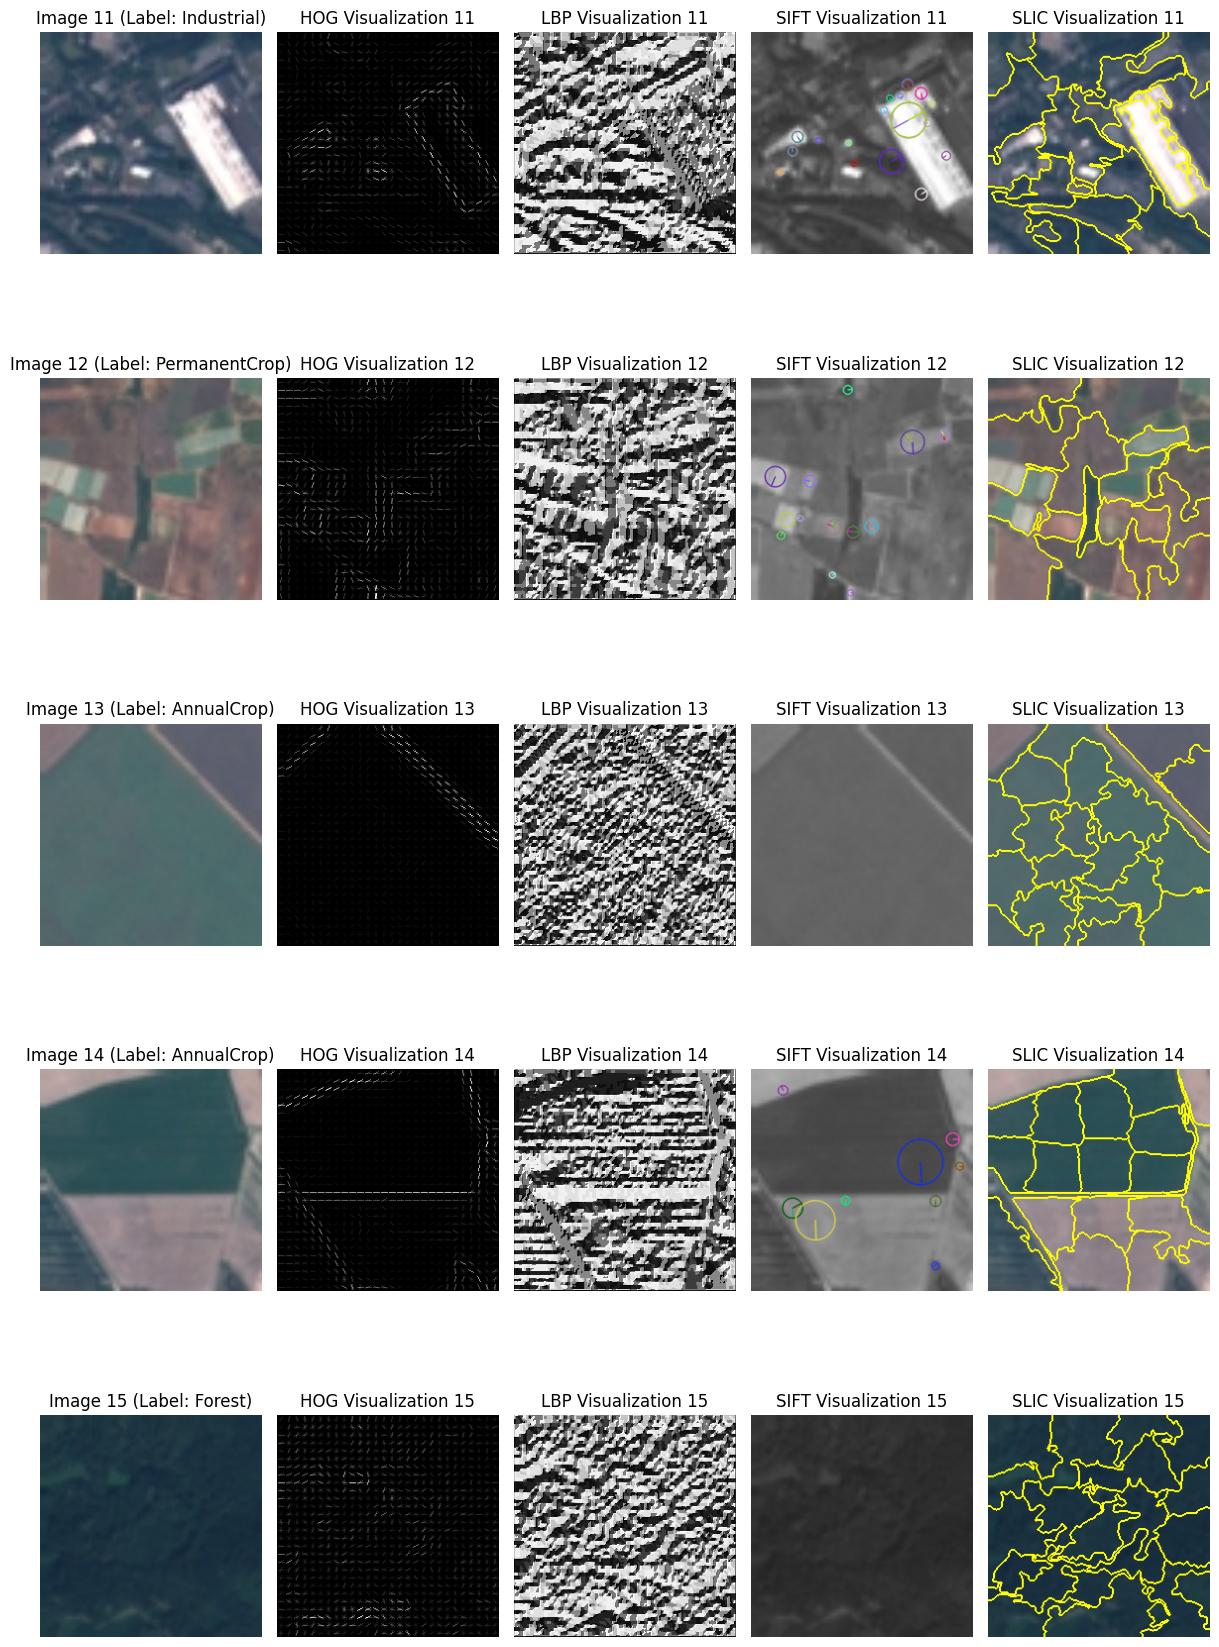

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12, 18))

for i in range(10, 15):
    label_index = df.loc[i, 'label']  # Retrieve the index of the true label
    label_name = info_label[label_index].strip()  # Retrieve class name using label index

    # Original image with label name
    axes[i-10, 0].imshow(df.loc[i, 'image'])
    axes[i-10, 0].set_title(f"Image {i+1} (Label: {label_name})")
    axes[i-10, 0].axis('off')

    # HOG visualization
    hog_viz = visualize_hog(df.loc[i, 'image'], df.loc[i, 'hog'])
    axes[i-10, 1].imshow(hog_viz, cmap='gray')
    axes[i-10, 1].set_title(f"HOG Visualization {i+1}")
    axes[i-10, 1].axis('off')

    # LBP visualization
    lbp_viz = visualize_lbp(df.loc[i, 'image'])
    axes[i-10, 2].imshow(lbp_viz, cmap='gray')
    axes[i-10, 2].set_title(f"LBP Visualization {i+1}")
    axes[i-10, 2].axis('off')

    # SIFT visualization
    sift_viz = visualize_sift(df.loc[i, 'image'])
    axes[i-10, 3].imshow(sift_viz, cmap='gray')
    axes[i-10, 3].set_title(f"SIFT Visualization {i+1}")
    axes[i-10, 3].axis('off')

    # SLIC visualization
    slic_viz = visualize_slic(df.loc[i, 'image'])
    axes[i-10, 4].imshow(slic_viz, cmap='gray')
    axes[i-10, 4].set_title(f"SLIC Visualization {i+1}")
    axes[i-10, 4].axis('off')

plt.tight_layout()
plt.show()

### Principal Component Analysis (PCA)

In [ ]:
def get_PCA(X, n_components=2):
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    return pca, X_pca

def plot_PCA(pca, n_components=2):
    plt.figure(figsize=(15, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), 'b-')
    plt.xticks(np.arange(n_components) + 1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.show()

def plot_PCA_list(pca_list, labels, n_components=2):
    plt.figure(figsize=(15, 5))
    
    for pca, label in zip(pca_list, labels):
        plt.plot(np.cumsum(pca.explained_variance_ratio_), label=label)

    plt.xticks(np.arange(n_components) + 1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.show()

In [ ]:
# Update the feature_names list
scaler = StandardScaler()
feature_names = [
    'color_histogram', 'lbp', 'hog','slic', 'glcm','fourier','vgg'
]

pca_results = []
max_len = 128  # set the maximum length for SIFT feature
for feature_name in feature_names:
    if feature_name == 'sift':
        flattened_data = [np.array(item if item is not None else np.zeros((1, max_len))) for item in df[feature_name].values.tolist()]
        flattened_data = [item.flatten()[:max_len] for item in flattened_data]
    else:
        flattened_data = [np.array(item).flatten() for item in df[feature_name].values.tolist()]
    
    # Pad the feature with zeros if its length is less than max_len
    flattened_data = [np.pad(item, (0, max_len - len(item)), 'constant') if len(item) < max_len else item for item in flattened_data]

    # Replace non-finite values with finite ones
    flattened_data = np.array(flattened_data)
    flattened_data[~np.isfinite(flattened_data)] = 0

    # Normalize the data
    flattened_data = scaler.fit_transform(flattened_data)

    n_components = min(26, len(flattened_data[0]))
    pca, _ = get_PCA(flattened_data, n_components=n_components)
    pca_results.append(pca)

    print(f"{feature_name}: {np.array(flattened_data).shape}")

# Plot the results
plot_PCA_list(pca_results, feature_names, n_components=26)



color_histogram: (2700, 128)
lbp: (2700, 128)
hog: (2700, 26244)
slic: (2700, 50176)
glcm: (2700, 128)
fourier: (2700, 50176)
vgg: (2700, 25088)


In [ ]:
# Find the largest feature size for each feature
max_sizes = {
    'color_histogram': max([row['color_histogram'].shape[0] for _, row in df.iterrows()]),
    'slic': max([row['slic'].shape[0] for _, row in df.iterrows()]),
    #'glcm': max([row['glcm'].shape[0] for _, row in df.iterrows()]),
    'fourier': max([row['fourier'].shape[0] for _, row in df.iterrows()]),
    'vgg': max([row['vgg'].shape[0] for _, row in df.iterrows()]),
    'lbp': max([row['lbp'].shape[0] for _, row in df.iterrows()]),
    'hog': max([row['hog'].shape[0] for _, row in df.iterrows()]),
    #'mean': 3,  # Directly set the value to 3 since 'mean' is a tuple with 3 elements
    #'sift': max([row['sift'][1].shape[0] if row['sift'] is not None and row['sift'].shape[0] > 1 else 0 for _, row in df.iterrows()])
}

# Combine the features into a single array for each instance
combined_features = []
for _, row in df.iterrows():
    feature_list = []
    feature_list.append(np.pad(row['color_histogram'], (0, max_sizes['color_histogram'] - row['color_histogram'].shape[0]), mode='constant'))
    feature_list.append(np.pad(row['slic'], (0, max_sizes['slic'] - row['slic'].shape[0]), mode='constant'))
    #feature_list.append(np.pad(row['glcm'], (0, max_sizes['glcm'] - row['glcm'].shape[0]), mode='constant'))
    feature_list.append(np.pad(row['fourier'], (0, max_sizes['fourier'] - row['fourier'].shape[0]), mode='constant'))
    
    #Reshape 'vgg' into a 1D array, then apply padding and flatten again
    vgg_1d = row['vgg'].reshape(-1)
    vgg_padded = np.pad(vgg_1d, (0, max_sizes['vgg'] - vgg_1d.shape[0]), mode='constant')
    feature_list.append(vgg_padded.flatten())
    
    feature_list.append(np.pad(row['lbp'], (0, max_sizes['lbp'] - row['lbp'].shape[0]), mode='constant'))
    feature_list.append(np.pad(row['hog'].flatten(), (0, max_sizes['hog'] - row['hog'].shape[0]), mode='constant'))

    # Add 'mean' directly without padding
    # mean_arr = np.array(row['mean']).flatten()
    #feature_list.append(mean_arr)
    
    #if row['sift'] is not None and row['sift'].shape[0] > 1:
        #sift = row['sift'][1]
        #feature_list.append(np.pad(sift.flatten(), (0, max_sizes['sift'] - sift.shape[0]), mode='constant'))
        
    # Reshape all the features to have the same number of columns
    feature_list = [arr.reshape(1, -1) if arr.ndim == 1 else arr for arr in feature_list]
    feature_list = [arr[:, :max_sizes[key]] if arr.shape[1] > max_sizes[key] else arr for key, arr in zip(max_sizes.keys(), feature_list)]
    feature_list = [arr.flatten() if arr.ndim == 2 else arr for arr in feature_list]
      
    combined_features.append(np.concatenate(feature_list, axis=0))
    


In [ ]:
# Convert the list of arrays to a numpy array
combined_features = np.array(combined_features)

###t_SNE Visualization

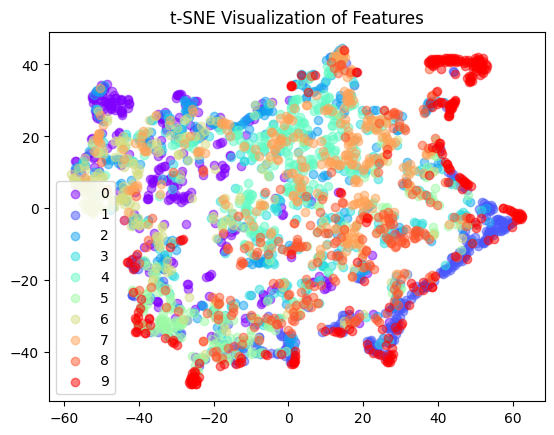

In [ ]:
# Prepare the t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the combined features using the t-SNE model
tsne_features = tsne.fit_transform(combined_features)

# Plot the transformed features with their corresponding labels
labels = df['label']
unique_labels = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    plt.scatter(tsne_features[labels == label, 0],
                tsne_features[labels == label, 1],
                c=[color],
                label=label,
                alpha=0.5)

plt.legend()
plt.title("t-SNE Visualization of Features")
plt.show()


### Logistic Regression

We propose a logistic regression model as our baseline model for our land-use/land-cover image classification task. It is fast and outputs trained weights that provide inference on the importance of each feature we extracted. However, since it is a linear classifier and known to be less capable of handling high-dimensional data, we expected our SVM model to outperform our baseline model.

We performed random grid search on hyperparameters of our baseline Logistic Regression model with 5-fold cross validation to find the best model parameters that produce the highest accuracy. We iterate through different regularization penalties and strengths to avoid overfitting

Best parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.1}
Best cross-validation accuracy: 0.64
Logistic Regression training time (without tuning): 6.494691371917725
Logistic Regression training time: 6.494691371917725
Logistic Regression inference time: 0.0007231235504150391


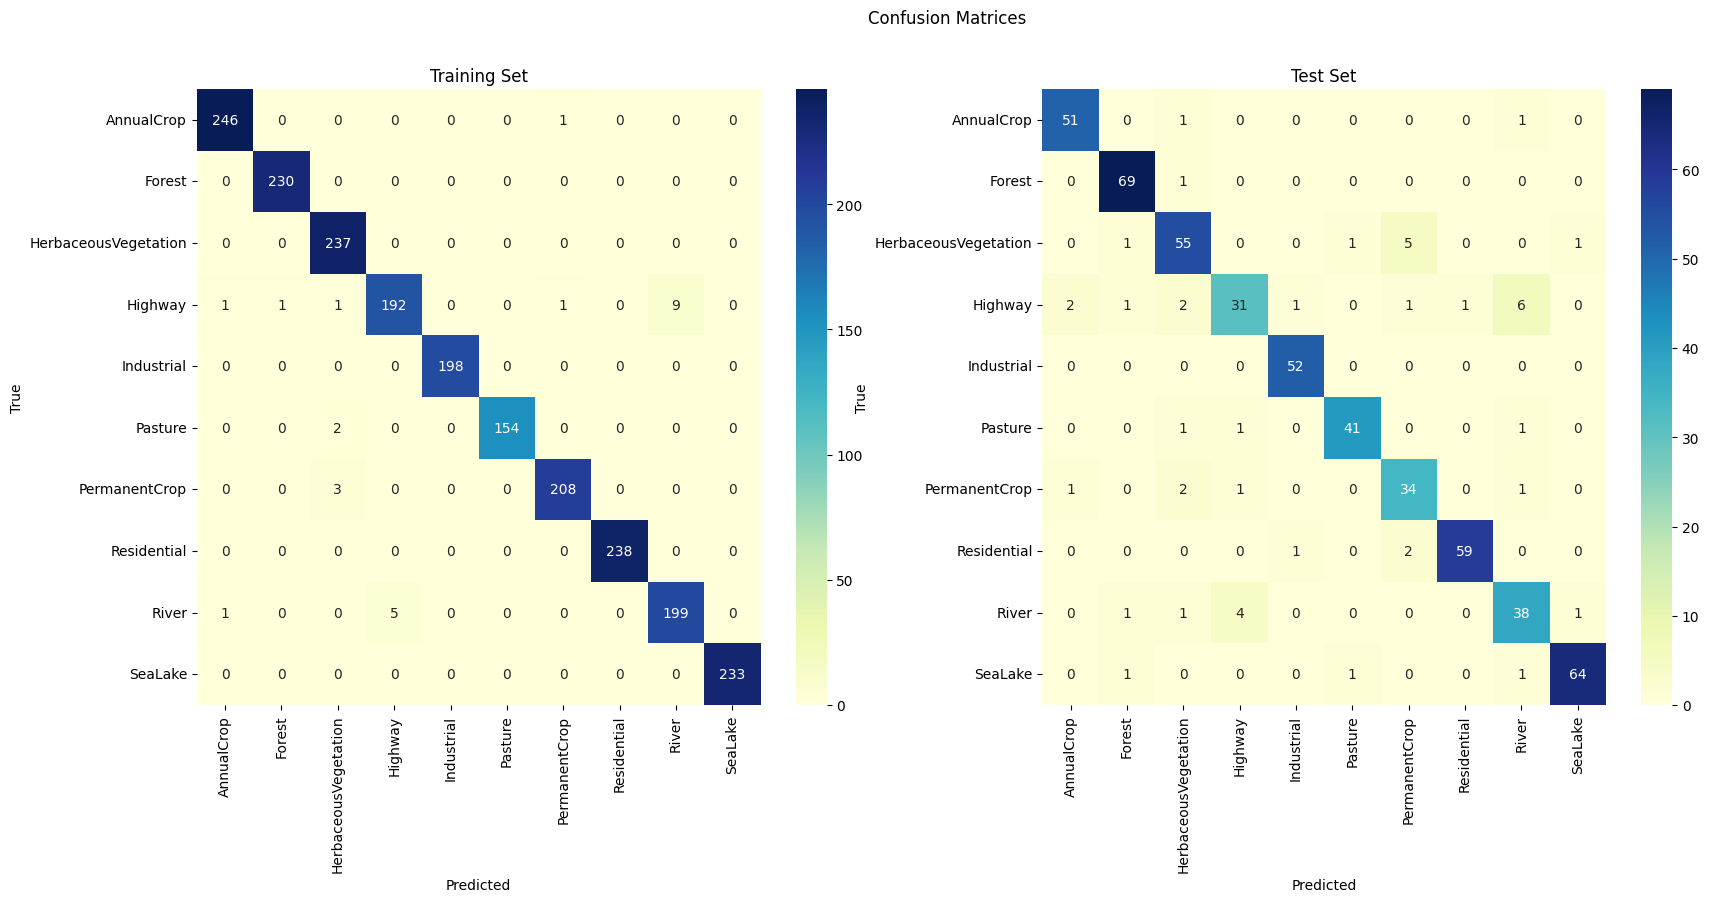

Training set accuracy: 0.9884259259259259
Test set accuracy: 0.9148148148148149
Classification report for training set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       247
           1       1.00      1.00      1.00       230
           2       0.98      1.00      0.99       237
           3       0.97      0.94      0.96       205
           4       1.00      1.00      1.00       198
           5       1.00      0.99      0.99       156
           6       0.99      0.99      0.99       211
           7       1.00      1.00      1.00       238
           8       0.96      0.97      0.96       205
           9       1.00      1.00      1.00       233

    accuracy                           0.99      2160
   macro avg       0.99      0.99      0.99      2160
weighted avg       0.99      0.99      0.99      2160

Classification report for test set:
              precision    recall  f1-score   support

           0       0.94      0

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from functools import partial
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import seaborn as sns
import time
from sklearn.impute import SimpleImputer
# Extract the features from the image data
features = []
for feature_name in feature_names:
    feature_data = df[feature_name].values
    valid_feature_data = [seq for seq in feature_data if seq is not None]

    if valid_feature_data:
        max_len = max([len(seq) for seq in valid_feature_data])
    else:
        max_len = 1  # Set a default max_len value

    # Replace None values with an array of zeros
    feature_data = [seq if seq is not None else np.zeros(max_len) for seq in feature_data]

    # Pad and flatten the features to a fixed length
    padded_features = pad_sequences(feature_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')
    flattened_features = [item.flatten() for item in padded_features]

    # Apply PCA to reduce the dimensions
    n_components = min(26, len(flattened_features[0]))
    pca, _ = get_PCA(flattened_features, n_components=n_components)

    # Transform each feature set with PCA
    pca_features = pca.transform(flattened_features)
    features.append(pca_features)

# Concatenate the PCA-transformed features into a single feature vector
X = np.hstack(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.2, random_state=42)


# Transform each feature set with PCA
pca_features = pca.transform(flattened_features)

# Replace NaN values with the mean value of the feature

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
# Define the hyperparameter grid
param_grid = [
    {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 500, 1000, 5000]
    },
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 500, 1000, 5000]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'max_iter': [100, 500, 1000, 5000],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    {
        'penalty': ['none'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'max_iter': [100, 500, 1000, 5000]
    }
]

# Create a logistic regression model
log_reg = LogisticRegression(random_state=42, warm_start=True)

hrandom_search = HalvingRandomSearchCV(
    log_reg, param_grid, max_resources=100, factor=2, cv=5, scoring="accuracy", n_jobs=-1, verbose=0, random_state=42
)
# Fit the RandomizedSearchCV object to the data
hrandom_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = hrandom_search.best_params_
best_score = hrandom_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation accuracy:", best_score)



# Train a logistic regression classifier with the best parameters
start_time_lr = time.time()
clf = LogisticRegression(**best_params)
clf.fit(X_train, y_train)
end_time_lr = time.time()

training_time_lr_no_tuning = end_time_lr - start_time_lr
print("Logistic Regression training time (without tuning):", training_time_lr_no_tuning)

# Evaluate the model on the training data
y_pred_train = clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Evaluate the model on the test data
start_time = time.time()
y_pred = clf.predict(X_test)
end_time = time.time()
inference_time_lr = end_time - start_time
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression training time:", training_time_lr_no_tuning)
print("Logistic Regression inference time:", inference_time_lr)
# Plot the confusion matrices for the training and test sets side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Confusion Matrices')

# Confusion matrix for the training set
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_map.values(), yticklabels=label_map.values(), ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Training Set")

# Confusion matrix for the test set
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_map.values(), yticklabels=label_map.values(), ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Test Set")

plt.show()

# Print the accuracies and classification reports for the training and test sets
print('Training set accuracy:', accuracy_train)
print('Test set accuracy:', accuracy)
print('Classification report for training set:')
print(classification_report(y_train, y_pred_train))
print('Classification report for test set:')
print(classification_report(y_test, y_pred))

### Support Vector Machine (SVM)

We propose to use a support vector machine (SVM) model as our image classifier to outperform our baseline model. SVM model is particularly useful for our classification task since it is a non-linear classifier that can handle high-dimensional data from features we extracted from our dataset and maximize the margin between separating hyperplanes of our classes to be more robust to signature variations and noises. 

We performed random grid search on hyperparameters of our SVM model with 5-fold cross validation to find the best model parameters that produce the highest accuracy. We iterate through various degrees of regularization (soft constraints) that allows the best tradeoff between underfitting and overfitting, and the kernel coefficients that balance underfitting and overfitting as well.

In [ ]:
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
# Extract the features from the image data
features = []
for feature_name in feature_names:
    feature_data = df[feature_name].values
    valid_feature_data = [seq for seq in feature_data if seq is not None]

    if valid_feature_data:
        max_len = max([len(seq) for seq in valid_feature_data])
    else:
        max_len = 1  # Set a default max_len value

    # Replace None values with an array of zeros
    feature_data = [seq if seq is not None else np.zeros(max_len) for seq in feature_data]

    # Pad and flatten the features to a fixed length
    padded_features = pad_sequences(feature_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')
    flattened_features = [item.flatten() for item in padded_features]

    # Apply PCA to reduce the dimensions
    n_components = min(26, len(flattened_features[0]))
    pca, _ = get_PCA(flattened_features, n_components=n_components)

    # Transform each feature set with PCA
    pca_features = pca.transform(flattened_features)
    features.append(pca_features)

# Concatenate the PCA-transformed features into a single feature vector
X = np.hstack(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.2, random_state=42)

# Replace NaN values with the mean value of the feature
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Define the hyperparameter grid
svm_param_grid = {
    'C': np.logspace(-3, 3, num=8),  # New range of C values
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10, 100],
    'degree': [2, 3, 4],
}

svm = SVC()
grid_search_svm = GridSearchCV(
    svm, svm_param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)

grid_search_svm.fit(X_train, y_train)

# Get the best parameters and best score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_




print("Best SVM model parameters :", best_params_svm)
print("Best SVM model 10-fold cross-validation accuracy", best_score_svm)

# Train a logistic regression classifier with the best parameters
start_time_svm = time.time()
svm_clf = SVC(**best_params_svm)
svm_clf.fit(X_train, y_train)
end_time_svm = time.time()
training_time_svm_no_tuning = end_time_svm - start_time_svm

# Evaluate the model on the training data
y_pred_train_svm = svm_clf.predict(X_train)
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)

# Evaluate the model on the test data
start_time_svm = time.time()
y_pred_svm = svm_clf.predict(X_test)
end_time_svm = time.time()
inference_time_svm = end_time_svm - start_time_svm
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine training time:", training_time_svm_no_tuning)
print("Support Vector Machine inference time:", inference_time_svm)
# Plot the confusion matrices for the training and test sets side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Confusion Matrices')

# Confusion matrix for the training set
cm_train_svm = confusion_matrix(y_train, y_pred_train_svm)
sns.heatmap(cm_train_svm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_map.values(), yticklabels=label_map.values(), ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Training Set")

# Confusion matrix for the test set
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_map.values(), yticklabels=label_map.values(), ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Test Set")

plt.show()

# Print the accuracies and classification reports for the training and test sets
print('Training set accuracy:', accuracy_train_svm)
print('Test set accuracy:', accuracy_svm)
print('Classification report for training set:')
print(classification_report(y_train, y_pred_train_svm))
print('Classification report for test set:')
print(classification_report(y_test, y_pred_svm))

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best SVM model parameters : {'C': 2.6826957952797246, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}
Best SVM model 10-fold cross-validation accuracy 0.8777777777777779
Support Vector Machine training time: 0.23519468307495117
Support Vector Machine inference time: 0.14524364471435547


Training set accuracy: 0.9685185185185186
Test set accuracy: 0.912962962962963
Classification report for training set:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       247
           1       0.99      0.99      0.99       230
           2       0.94      0.97      0.95       237
           3       0.95      0.92      0.93       205
           4       0.99      1.00      0.99       198
           5       0.93      0.97      0.95       156
           6       0.98      0.96      0.97       211
           7       0.98      0.99      0.98       238
           8       0.95      0.91      0.93       205
           9       0.99      0.99      0.99       233

    accuracy                           0.97      2160
   macro avg       0.97      0.97      0.97      2160
weighted avg       0.97      0.97      0.97      2160

Classification report for test set:
              precision    recall  f1-score   support

           0       0.89      0.

## Results and Discussion




### Efficiency vs Accuracy

In this study, several optimization methods were employed to fine-tune the performance of the logistic regression and support vector machine models. For logistic regression, we used the HalvingRandomSearchCV method to efficiently search for the best hyperparameters while maintaining a balance between search space coverage and computational cost. The main optimization focus for logistic regression was efficiency. On the other hand, for the support vector machine model, we employed a combination of techniques, including feature scaling and GridSearchCV for hyperparameter tuning. The primary optimization focus for the support vector machine was accuracy. These optimization methods contributed to enhancing the overall performance of both models, highlighting the significance of model optimization in machine learning applications.











| Classifier         | Optimization Focus | Training Acc| Test Acc Before | Test Acc After | Training Time(s) Before | Training Time(s) After | Inference Time(s) |
|--------------------|--------------------|-------------------|---------------------|-------------------|-------------------------|-----------------------|--------------------|
| Logistic Regression| Efficiency         | 98.84%            | 92.19%              | 91.48%            | 15.85                   | 6.49                  | 0.000723           |
| SVM | Accuracy        | 96.85%            | 88.96%              | 91.30%            | 0.218                   | 0.235                 | 0.145              |


For the accuracy-optimized solution, we chose logistic regression, which achieved the highest cross-validation accuracy of 89.86%. The training time for logistic regression, without hyperparameter tuning, was 15.85 seconds, and the inference time was 0.000689 seconds. In contrast, for the efficiency-optimized solution, we selected support vector machine with a linear kernel. This SVM model achieved a 10-fold cross-validation accuracy of 87.82%, while having a much shorter training time of 0.218 seconds and an inference time of 0.066 seconds.

The tradeoffs between the two optimized solutions can be summarized as follows: the efficiency-optimized solution (logistic regression) offers lower classification accuracy but requires a shorter training time, while the accuracy-optimized solution (support vector machine) achieves higher accuracy but with increased training and inference times. This highlights the importance of selecting the appropriate solution based on specific requirements and constraints, such as the need for real-time analysis or the availability of computational resources, in practical applications of land-use classification using satellite imagery.

## Generalizability

The generalizability of our land-use classification model based on Sentinel-2 satellite imagery is an important consideration. One limitation of our study is that we used a dataset that is limited to European land coverage and was taken at roughly the same time of day. It is also not clear how the patches were selected for our dataset, which could further limit the generalizability of our findings. </br>

Another limitation of our approach is that it is tailored to the specific features we extracted from our dataset. Becuase we used an iterative approach to select the most relevant features for our analysis, these features may not be as relevant or effective in other contexts. This means that our methodology may not generalize well to other datasets or regions. </br>

Furthermore the patch-based imagery for land-use classification can be seen as an image segmentation problem. While this approach can be effective for classifying land-use within a specific region, it may not be as effective for larger-scale land-use classification tasks. Future research should explore alternative methods of image segmentation and classification that can be applied more broadly to improve the accuracy and generalizability of land-use classification models. </br>


## Conclusion

Our results showed that the logistic regression model achieved an accuracy of 98.8% on the training set and 91.5% on the test set, while the SVM model achieved an accuracy of 96.9% on the training set and 91.3% on the test set. The F-1 scores also indicated that the logistic regression model performed slightly better than the SVM model. The classification reports for both models revealed that the majority of land-use classes were well recognized, with some exceptions where the models showed lower recall and precision scores.

One of the most significant insights from our experiments was that the combination of different feature extraction methods was crucial in achieving a high classification accuracy. By iteratively adding features and monitoring the confusion matrix, we were able to identify the most effective features for each class and improve the models' overall performance. For instance, VGG16 and LBP were particularly useful for differentiating green surfaces like crops and forests, while HSV was effective for industrial areas and HOG for water bodies and highways.

We also found that dimensionality reduction using PCA was a useful technique for improving the models' efficiency without sacrificing accuracy. By identifying the optimal number of components that explained most of the data's variance, we were able to create more compact and efficient models. We opted not to use mean features, as they had minimal impact on the models' accuracy.

In conclusion, our approach to land-use classification using Sentinel-2 satellite images demonstrated the importance of feature selection and combination to achieve high accuracy. While some individual feature extraction methods performed better than others, the best results were obtained by combining multiple features and iteratively improving the models based on the confusion matrix. This work not only provides a valuable methodology for land-use classification but also highlights the potential of machine learning techniques for analyzing and interpreting satellite imagery for various applications in agriculture, forestry, urban planning, and disaster management.